In [88]:
import carbonbench

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

In [87]:
import importlib
import carbonbench
importlib.reload(carbonbench)

<module 'carbonbench' from '/users/4/rozan012/CarbonBench/carbonbench/__init__.py'>

# Process Targets

In [89]:
# 1 Process targets
# 1.1 Load targets
targets = ['GPP_NT_VUT_USTAR50', 'RECO_NT_VUT_USTAR50', 'NEE_VUT_USTAR50']
include_qc = True
test_QC_threshold = 1 # [0,1] with 1 being the highest quality data
y = carbonbench.load_targets(targets, include_qc)
y

date        site        lat         lon IGBP Koppen  \
0       2009-01-01  FLX_AR-SLu -33.464800  -66.459800   MF      B   
1       2009-01-02  FLX_AR-SLu -33.464800  -66.459800   MF      B   
2       2009-01-03  FLX_AR-SLu -33.464800  -66.459800   MF      B   
3       2009-01-04  FLX_AR-SLu -33.464800  -66.459800   MF      B   
4       2009-01-05  FLX_AR-SLu -33.464800  -66.459800   MF      B   
...            ...         ...        ...         ...  ...    ...   
1435909 2023-12-27  JPX_JP-Tmd  42.735911  141.523147  DBF      D   
1435910 2023-12-28  JPX_JP-Tmd  42.735911  141.523147  DBF      D   
1435911 2023-12-29  JPX_JP-Tmd  42.735911  141.523147  DBF      D   
1435912 2023-12-30  JPX_JP-Tmd  42.735911  141.523147  DBF      D   
1435913 2023-12-31  JPX_JP-Tmd  42.735911  141.523147  DBF      D   

        Koppen_short  GPP_NT_VUT_USTAR50  RECO_NT_VUT_USTAR50  \
0                BSh            8.989840             2.957700   
1                BSh            8.912250             2.977330   
2                BSh            9.356500             3.330460   
3                BSh            9.826600             3.794460   
4                BSh            9.727970             3.793040   
...              ...                 ...                  ...   
1435909          Dfb            1.013866             0.617556   
1435910          Dfb            0.738017             0.734304   
1435911          Dfb            0.744890             0.765398   
1435912          Dfb            0.470808             0.907578   
1435913          Dfb            0.207919             0.780453   

         NEE_VUT_USTAR50  NEE_VUT_USTAR50_QC  
0              -6.032130                 0.0  
1              -5.934920                 0.0  
2              -6.026040                 0.0  
3              -6.032130                 0.0  
4              -5.934920                 0.0  
...                  ...                 ...  
1435909        -0.396310                 0.0  
1435910        -0.003712                 0.0  
1435911         0.020508                 0.0  
1435912         0.436770                 0.0  
1435913         0.572534                 0.0  

[1304309 rows x 11 columns]

In [45]:
# 1.2 Explore targets
print(f"Total number of sites: {y.site.nunique()}")
print(f"Total number of samples: {len(y)}, QC∈[0,1]")
if include_qc:
    print(f"Total number of top-quality samples: {len(y[y.NEE_VUT_USTAR50_QC==1])}, QC=1")

Total number of sites: 567
Total number of samples: 1304309, QC∈[0,1]
Total number of top-quality samples: 553467, QC=1


Train sites: 448, Test sites: 119

IGBP balance:
      overall  test
IGBP               
CRO        70    14
CSH         9     4
CVM         4     2
DBF        83    17
DNF        12     2
EBF        21     4
ENF       125    25
GRA        90    18
MF         23     5
OSH        36     7
SAV        12     3
SNO         2     1
URB         2     1
WAT         2     1
WET        64    13
WSA        12     2


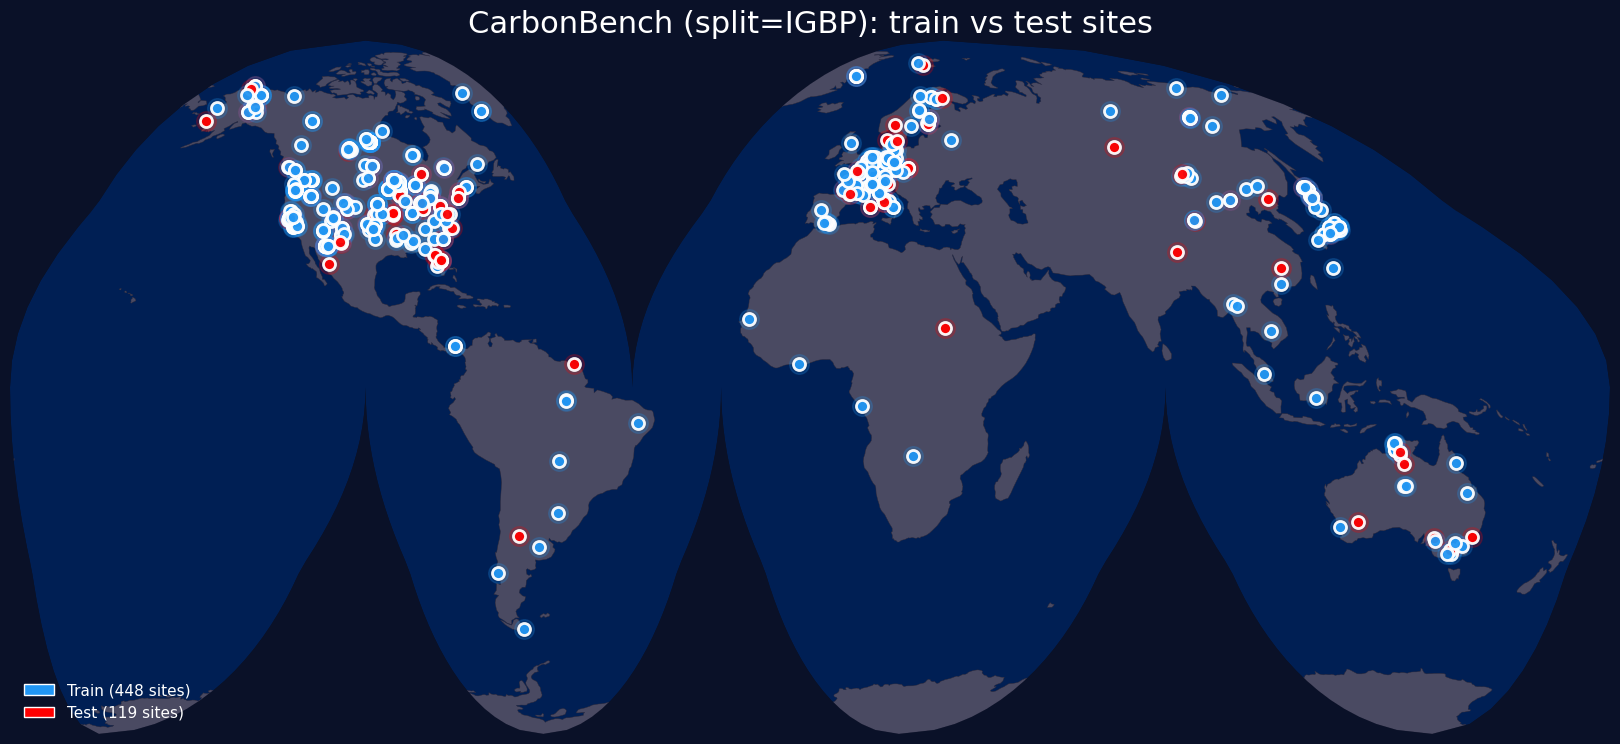

In [90]:
# 1.3 Split targets on train and test (site holdout)
task_type = 'zero-shot'# 'few-shot'
split_type = 'IGBP' # 'IGBP'
y_train, y_test = carbonbench.split_targets(y, task_type, split_type, verbose=True, plot=True)

# Process Features

In [91]:
modis = carbonbench.load_modis()

era_feature_set = 'minimal' # minimal (6), standard (36), full (150)
era = carbonbench.load_era(era_feature_set)

train, val, test, x_scaler, y_scaler = carbonbench.join_features(y_train, y_test, modis, era, scale=True)

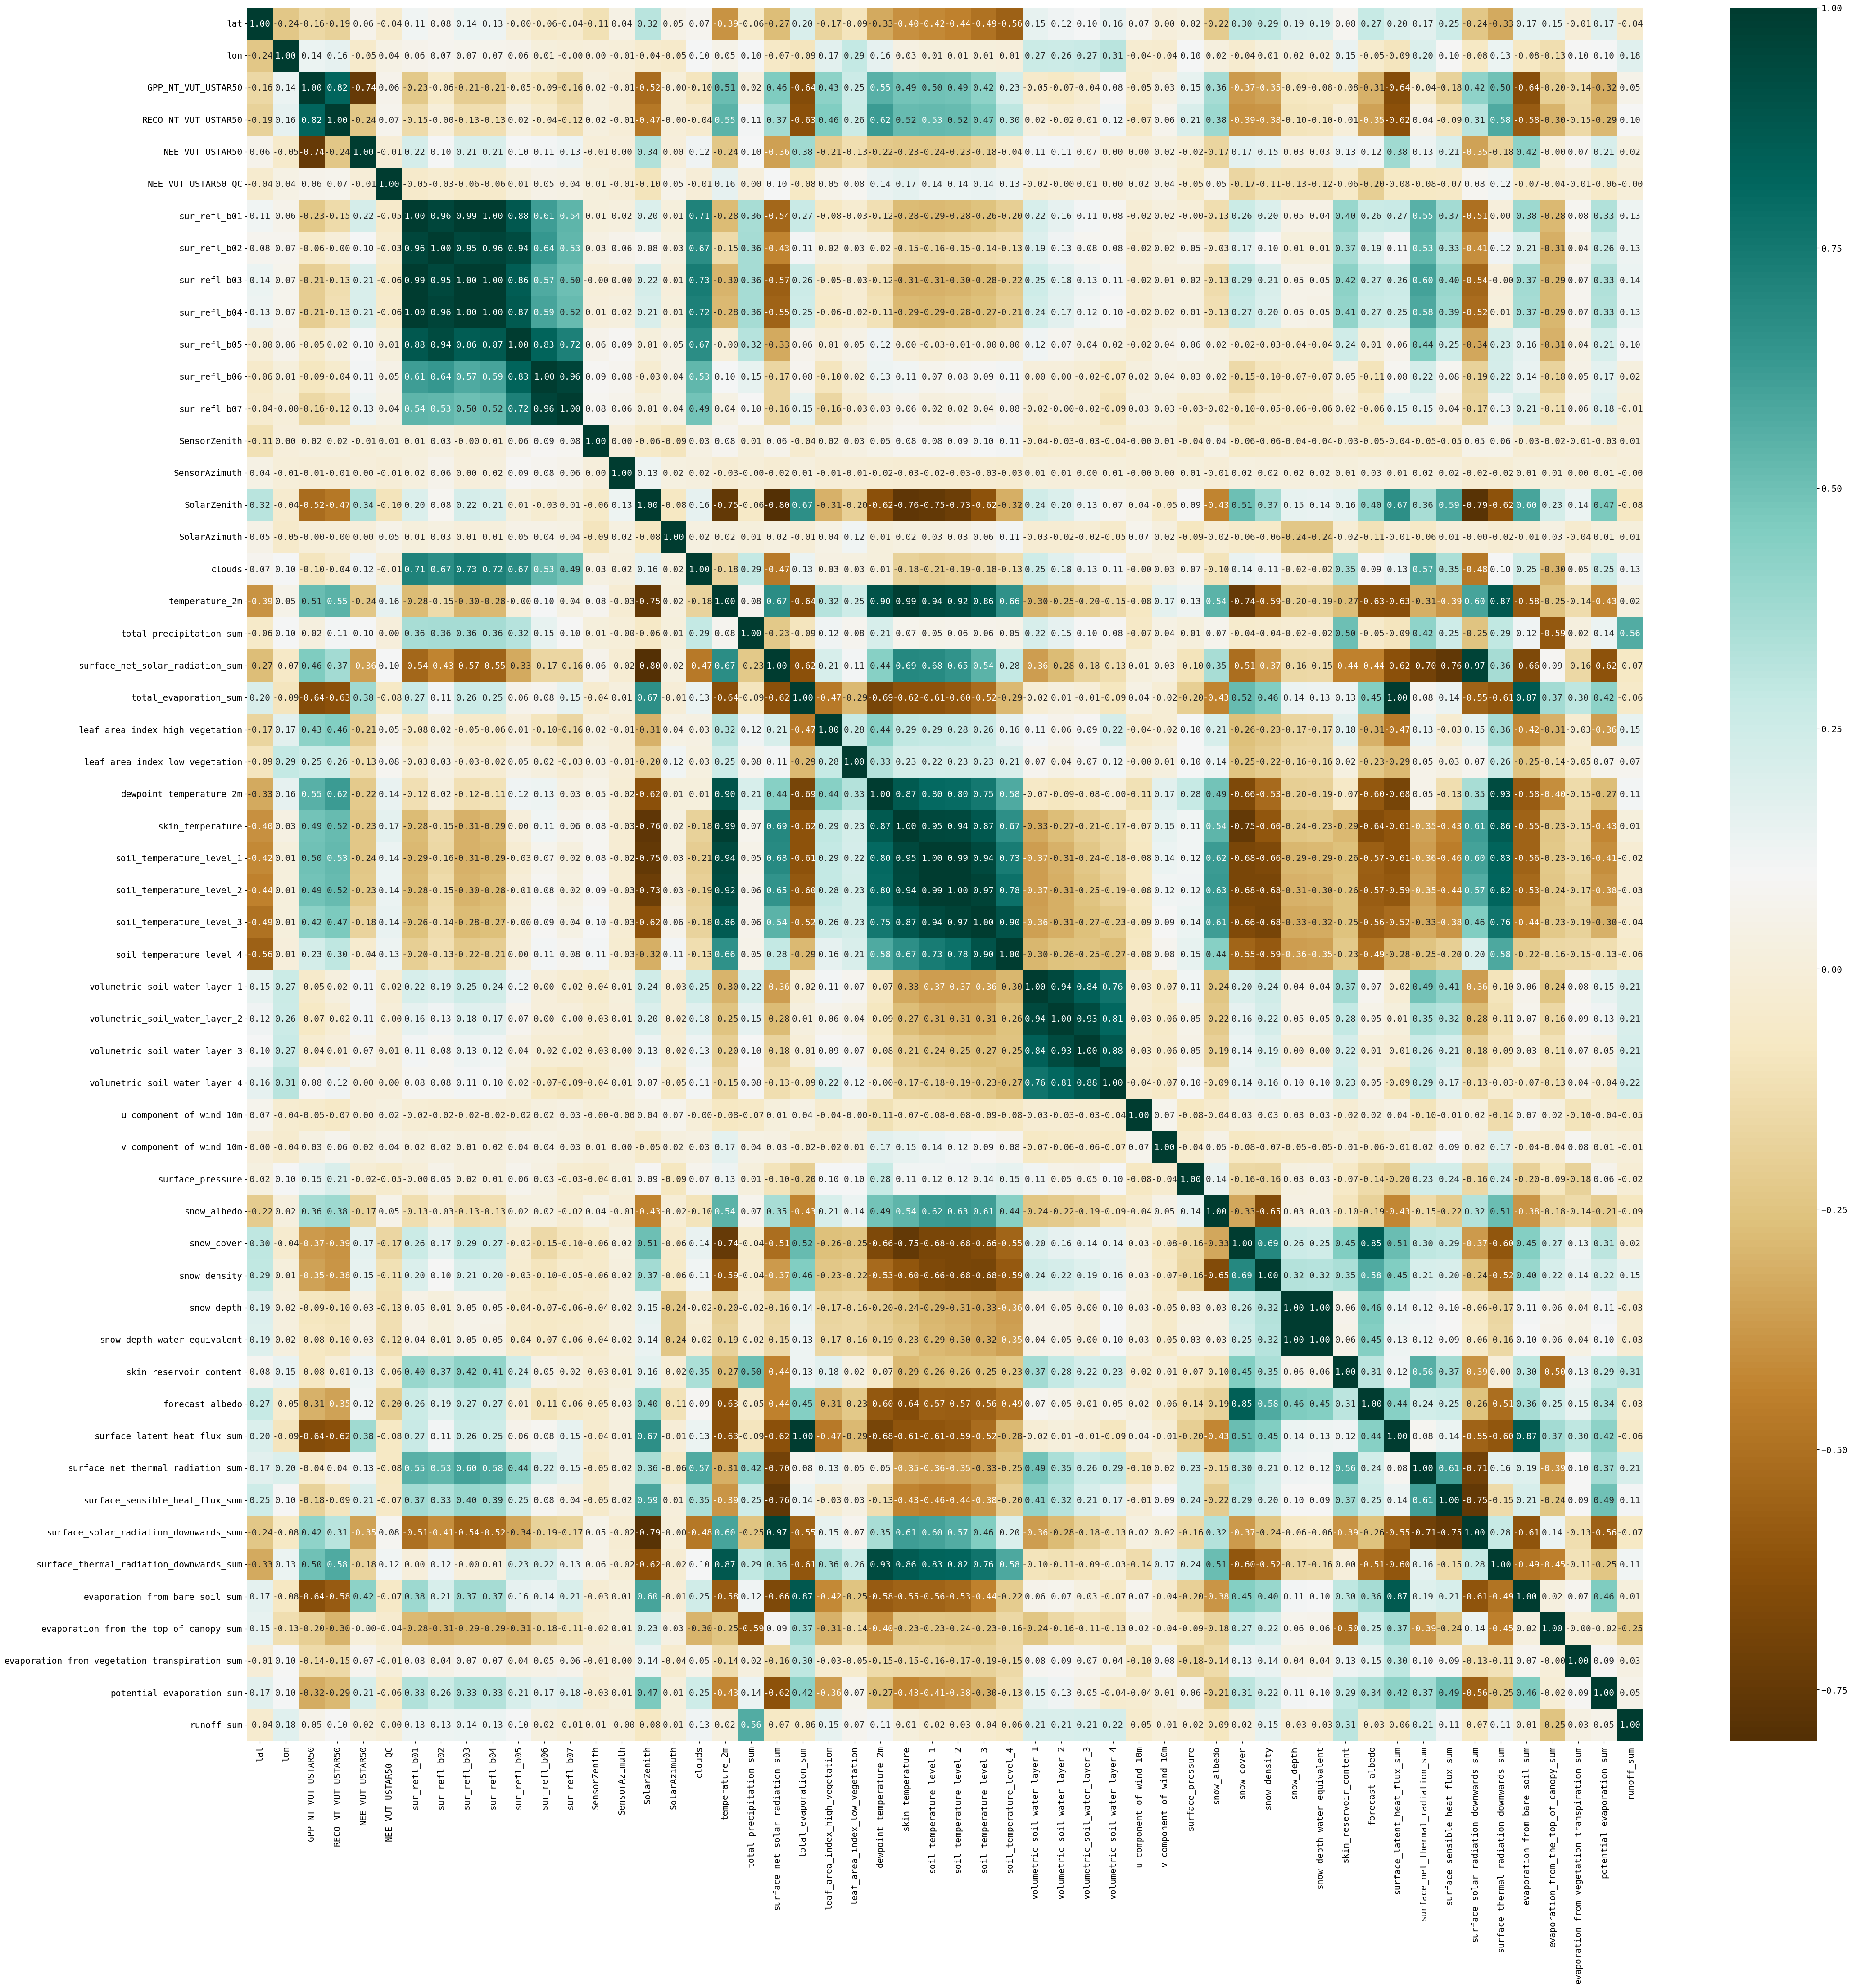

In [8]:
carbonbench.plot_feature_heatmap(train, save_path='./', figsize=(50,50)) # full figsize=(150,150), minimal figsize=(25,25)

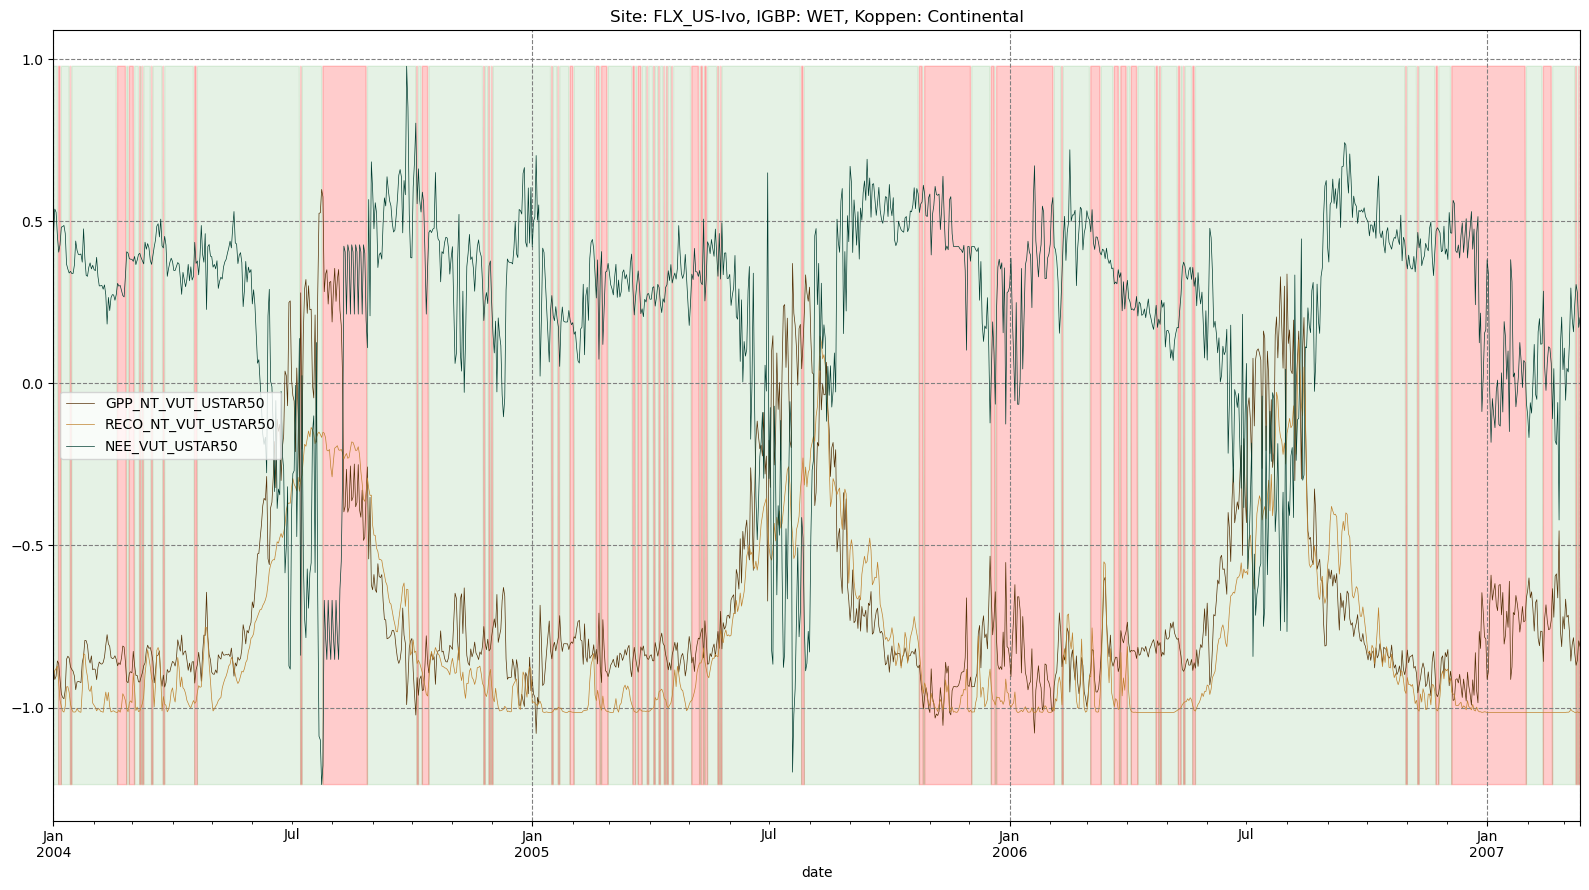

In [5]:
carbonbench.plot_site_ts(train, targets, include_qc, qc_threshold=0.75, site_name='FLX_US-Ivo', save_path=None)

In [19]:
'''Sliding Window (for time series modeling in torch)'''
batch_size = 32
window_size = 30
stride = 15 # make equal to window_size for full x_i, y_i parity 

train_hist = carbonbench.historical_cache(train, era, modis, x_scaler, window_size)
train_dataset = carbonbench.SlidingWindowDataset(train_hist, targets, include_qc, window_size=window_size, stride=stride, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_hist = carbonbench.historical_cache(val, era, modis, x_scaler, window_size)
val_dataset = carbonbench.SlidingWindowDataset(val_hist, targets, include_qc, window_size=window_size, stride=stride, encoders=train_dataset.encoders,
                                               cat_features=['IGBP', 'Koppen', 'Koppen_short'])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [92]:
'''Tabular Processing (RF, XGBoost, etc.)'''
X_train_tab, y_train_tab, y_train_qc_tab = carbonbench.tabular(train, targets, include_qc, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
X_val_tab, y_val_tab, y_val_qc_tab = carbonbench.tabular(val, targets, include_qc, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
X_test_tab, y_test_tab, y_test_qc_tab = carbonbench.tabular(test, targets, include_qc, test_QC_threshold, cat_features=['IGBP', 'Koppen', 'Koppen_short'])

# Baselines

In [93]:
results = {}

## Tree Models

In [50]:
import xgboost as xgb

In [94]:
dtrain = xgb.DMatrix(X_train_tab.drop('site', axis=1), label=y_train_tab, weight=y_train_qc_tab.clip(1e-2, 1), enable_categorical=True)
dval = xgb.DMatrix(X_val_tab.drop('site', axis=1), label=y_val_tab, enable_categorical=True)

params = {
    'colsample_bynode': 1,
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_parallel_tree': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'min_child_weight': 5
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'validation')],
    verbose_eval=50,
)

[0]	validation-rmse:0.96965
[50]	validation-rmse:0.59820
[100]	validation-rmse:0.57837
[150]	validation-rmse:0.57358
[200]	validation-rmse:0.57098
[250]	validation-rmse:0.56955
[300]	validation-rmse:0.56867
[350]	validation-rmse:0.56802
[400]	validation-rmse:0.56757
[450]	validation-rmse:0.56718
[498]	validation-rmse:0.56691


In [95]:
results['XGBoost'] = carbonbench.eval_tree_model(X_test_tab, y_test_tab, targets, model, y_scaler, method='xgb')

			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	-0.226	2.174	0.855	0.619
RECO_NT_VUT_USTAR50:	-0.908	1.746	1.125	0.715
NEE_VUT_USTAR50:	-0.094	1.565	0.968	5.106


# PyTorch

In [18]:
'''Compute Upsampling Weights for the Custom Loss Function'''
IGBP = train['IGBP'].values
IGBP_weights = compute_class_weight(class_weight="balanced", classes=np.unique(IGBP), y=IGBP)
IGBP_weights = {str(k): float(IGBP_weights[i]) for i,k in enumerate(np.unique(IGBP))}

Koppen = train['Koppen'].values
Koppen_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Koppen), y=Koppen)
Koppen_weights = {str(k): float(Koppen_weights[i]) for i,k in enumerate(np.unique(Koppen))}

In [20]:
test_hist = carbonbench.historical_cache(test, era, modis, x_scaler, window_size)
test_dataset = carbonbench.SlidingWindowDataset(test_hist, targets, include_qc, window_size=window_size, QC_threshold=test_QC_threshold, stride=1, cat_features=['IGBP', 'Koppen', 'Koppen_short'],
                                    encoders=train_dataset.encoders)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [21]:
input_dynamic_channels = 20 # 12 - MODIS + lat + lon + ERA (6/36/150)
input_static_channels = sum(len(train_dataset.encoders[k].categories_[0]) for k in ("IGBP", "Koppen", "Koppen_short"))
hidden_dim = 128
latent_dim = 32 # TAM-RL specific
output_channels = len(targets)
dropout = 0.2
nhead = 4
layers = 1
tf_layers = 4
patch_len = 10
patch_stride = 5
num_epoch = 25
device = 'cuda'

## Train one model

In [56]:
model = carbonbench.ctlstm(input_dynamic_channels, input_static_channels, hidden_dim, output_channels, dropout, layers).to(device)
# model = carbonbench.patch_transformer(input_dynamic_channels, input_static_channels, output_channels,
#         window_size, stride, patch_len, patch_stride, hidden_dim, nhead, tf_layers, dropout).to(device)
#model = carbonbench.transformer(input_dynamic_channels, input_static_channels, output_channels, window_size, hidden_dim, nhead, tf_layers, dropout).to(device)
architecture = model.__class__.__name__

In [57]:
criterion = carbonbench.CustomLoss(IGBP_weights, Koppen_weights) #torch.nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [58]:
best = np.inf
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, x_static, y, qc, igbp_w, koppen_w in train_loader:
        x, x_static, y, qc, igbp_w, koppen_w = x.to(device), x_static.to(device), y.to(device), qc.to(device), igbp_w.to(device), koppen_w.to(device)
        optimizer.zero_grad()
        if architecture in ['lstm', 'gru']:
            pred = model(x)
        else:
            pred = model(x, x_static)
            
        if criterion.__class__.__name__=='CustomLoss':
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3], qc, igbp_w, koppen_w)
        else:
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3])
            
        error.backward()
        optimizer.step()
    scheduler.step()
    
    if epoch % 5 == 0:
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for x, x_static, y, _, _, _ in val_loader:
                x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                if architecture in ['lstm', 'gru']:
                    preds = model(x)
                else:
                    preds = model(x, x_static)
                val_preds.append(preds.detach().cpu())
                val_true.append(y.detach().cpu())
        val_preds = torch.cat(val_preds).squeeze()
        val_true = torch.cat(val_true).squeeze()
        
        val_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

        best_old = best
        best = min(val_loss, best)
#         if abs(best) < best_old:
#             torch.save(model.state_dict(), f'{model_folder}/model_state.pth')
        print(f'Validation RMSE: {val_loss:0.3f}')

  4%|█▊                                          | 1/25 [00:38<15:13, 38.08s/it]

Validation RMSE: 0.487


 24%|██████████▌                                 | 6/25 [03:30<11:10, 35.31s/it]

Validation RMSE: 0.411


 44%|██████████████████▉                        | 11/25 [06:22<08:12, 35.19s/it]

Validation RMSE: 0.377


 64%|███████████████████████████▌               | 16/25 [09:14<05:16, 35.12s/it]

Validation RMSE: 0.380


 84%|████████████████████████████████████       | 21/25 [12:06<02:20, 35.00s/it]

Validation RMSE: 0.371


100%|███████████████████████████████████████████| 25/25 [14:20<00:00, 34.40s/it]


In [59]:
results[architecture] = carbonbench.eval_nn_model(test_dataset, test, targets, model, architecture, device, y_scaler, window_size)

			R2	RMSE	RAE	nMAE
GPP_NT_VUT_USTAR50:	0.209	1.876	0.675	0.682
RECO_NT_VUT_USTAR50:	-0.099	1.474	0.844	0.481
NEE_VUT_USTAR50:	-0.642	1.594	1.016	6.424


# Train TAM-RL model

1. Pre-train the decoder (lstm);
2. Train TAM-RL (AE + TAMLSTM).

In [10]:
model = carbonbench.lstm(input_dynamic_channels, hidden_dim, output_channels, dropout, layers).to(device)
architecture = model.__class__.__name__

criterion = carbonbench.CustomLoss(IGBP_weights, Koppen_weights) #torch.nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [11]:
'''Pre-training'''
best = np.inf
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, x_static, y, qc, igbp_w, koppen_w in train_loader:
        x, x_static, y, qc, igbp_w, koppen_w = x.to(device), x_static.to(device), y.to(device), qc.to(device), igbp_w.to(device), koppen_w.to(device)
        optimizer.zero_grad()
        if architecture in ['lstm', 'gru']:
            pred = model(x)
        else:
            pred = model(x, x_static)
            
        if criterion.__class__.__name__=='CustomLoss':
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3], qc, igbp_w, koppen_w)
        else:
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3])
            
        error.backward()
        optimizer.step()
    scheduler.step()
    
    if epoch % 5 == 0:
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for x, x_static, y, _, _, _ in val_loader:
                x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                if architecture in ['lstm', 'gru']:
                    preds = model(x)
                else:
                    preds = model(x, x_static)
                val_preds.append(preds.detach().cpu())
                val_true.append(y.detach().cpu())
        val_preds = torch.cat(val_preds).squeeze()
        val_true = torch.cat(val_true).squeeze()
        
        val_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

        best_old = best
        best = min(val_loss, best)
        if best < best_old:
            best_model = model.state_dict()
        print(f'Validation RMSE: {val_loss:0.3f}')

  4%|█▊                                          | 1/25 [00:36<14:37, 36.58s/it]

Validation RMSE: 0.542


 24%|██████████▌                                 | 6/25 [03:20<10:39, 33.65s/it]

Validation RMSE: 0.504


 44%|██████████████████▉                        | 11/25 [06:06<07:51, 33.69s/it]

Validation RMSE: 0.435


 64%|███████████████████████████▌               | 16/25 [08:50<05:01, 33.52s/it]

Validation RMSE: 0.433


 84%|████████████████████████████████████       | 21/25 [11:34<02:13, 33.49s/it]

Validation RMSE: 0.425


100%|███████████████████████████████████████████| 25/25 [13:42<00:00, 32.89s/it]


In [12]:
model.load_state_dict(best_model)
results['lstm'] = carbonbench.eval_nn_model(test_dataset, test, targets, model, 'lstm', device, y_scaler, window_size)

			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.51	1.94	0.81
RECO_NT_VUT_USTAR50:	0.37	1.59	0.58
NEE_VUT_USTAR50:	0.28	1.65	5.65


In [59]:
inverse_model = carbonbench.ae_tamrl(input_channels=input_dynamic_channels+input_static_channels, 
                       code_dim=latent_dim, hidden_dim=latent_dim, output_channels=latent_dim).to(device)
#forward_model = carbonbench.tamlstm(input_dynamic_channels, latent_dim, hidden_dim, output_channels, dropout).to(device)
forward_model = carbonbench.ctlstm_decoder(input_dynamic_channels, latent_dim, hidden_dim, output_channels, dropout).to(device)
architecture = inverse_model.__class__.__name__

encoder_weights = {k.replace('encoder.', ''): v for k, v in best_model.items() if k.startswith('encoder.')}
forward_model.encoder.load_state_dict(encoder_weights)

criterion = carbonbench.CustomLoss(IGBP_weights, Koppen_weights) #torch.nn.MSELoss() 
optimizer = optim.Adam(list(inverse_model.parameters())+list(forward_model.parameters()), lr=1e-3) 
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [23]:
train_dataset_tamrl = carbonbench.SlidingWindowDatasetTAMRL(train_hist, targets, include_qc, window_size=window_size, stride=stride, cat_features=['IGBP', 'Koppen', 'Koppen_short'])
train_loader_tamrl = DataLoader(train_dataset_tamrl, batch_size=batch_size, shuffle=True)

val_dataset_tamrl = carbonbench.SlidingWindowDatasetTAMRL(val_hist, targets, include_qc, window_size=window_size, stride=stride, encoders=train_dataset.encoders,
                                               cat_features=['IGBP', 'Koppen', 'Koppen_short'])
val_loader_tamrl = DataLoader(val_dataset_tamrl, batch_size=batch_size, shuffle=True)

test_dataset_tamrl = carbonbench.SlidingWindowDatasetTAMRL(test_hist, targets, include_qc, window_size=window_size, QC_threshold=test_QC_threshold, stride=1, cat_features=['IGBP', 'Koppen', 'Koppen_short'],
                                    encoders=train_dataset.encoders) 
test_loader_tamrl = DataLoader(test_dataset_tamrl, batch_size=batch_size, shuffle=False, drop_last=False)

In [68]:
'''Training TAM-RL'''
best = np.inf
for epoch in tqdm(range(num_epoch)):
    inverse_model.train()
    forward_model.train()
    for x, x_static, y, qc, igbp_w, koppen_w, x_sup, x_static_sup in train_loader_tamrl:
        x, x_static, y, qc, igbp_w, koppen_w, x_sup, x_static_sup = x.to(device), x_static.to(device), y.to(device), qc.to(device),\
                                                                    igbp_w.to(device), koppen_w.to(device), x_sup.to(device), x_static_sup.to(device)
        optimizer.zero_grad()
        
        batch, window, _ = x.shape
        batch_dynamic_input = torch.cat((x, x_sup), dim=0)
        batch_static_input = torch.cat((x_static, x_static_sup), dim=0)

        batch_input = torch.cat((batch_dynamic_input, batch_static_input), dim=-1).to(device)
        latent_repr, _,_,_ = inverse_model(x=batch_input.float())
        
        batch_static_input = latent_repr[:x.shape[0]].unsqueeze(1).repeat(1, window, 1) # GET BATCH DATA FOR FORWARD MODEL
        pred = forward_model(x_dynamic=x.float().to(device), x_static=batch_static_input.float().to(device))
            
        if criterion.__class__.__name__=='CustomLoss':
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3], qc, igbp_w, koppen_w)
        else:
            error = criterion(pred[:,-stride:, :], y[:,-stride:,:3])
            
        error.backward()
        optimizer.step()
    scheduler.step()
    
    if epoch % 5 == 0:
        inverse_model.eval()
        forward_model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for x, x_static, y, _, _, _, x_sup, x_static_sup in val_loader_tamrl:
                x, x_static, y, x_sup, x_static_sup = x.to(device), x_static.to(device), y.squeeze().to(device), x_sup.to(device), x_static_sup.to(device)

                batch, window, _ = x.shape
                batch_dynamic_input = torch.cat((x, x_sup), dim=0)
                batch_static_input = torch.cat((x_static, x_static_sup), dim=0)

                batch_input = torch.cat((batch_dynamic_input, batch_static_input), dim=-1).to(device)
                latent_repr, _,_,_ = inverse_model(x=batch_input.float())

                batch_static_input = latent_repr[:x.shape[0]].unsqueeze(1).repeat(1, window, 1) # GET BATCH DATA FOR FORWARD MODEL
                pred = forward_model(x_dynamic=x.float().to(device), x_static=batch_static_input.float().to(device))
                
                val_preds.append(pred.detach().cpu())
                val_true.append(y.detach().cpu())
        val_preds = torch.cat(val_preds).squeeze()
        val_true = torch.cat(val_true).squeeze()
        
        #val_loss = criterion(val_preds.to(device)[:,-1:,:], val_true[:, :3].to(device))
        val_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

        best_old = best
        best = min(val_loss, best)
        if best < best_old:
            best_model_fw = forward_model.state_dict()
            best_model_inv = inverse_model.state_dict()
        print(f'Validation RMSE: {val_loss:0.3f}')

  4%|███▋                                                                                       | 1/25 [01:00<24:00, 60.04s/it]

Validation RMSE: 0.533


 24%|█████████████████████▊                                                                     | 6/25 [05:29<17:32, 55.41s/it]

Validation RMSE: 0.483


 44%|███████████████████████████████████████▌                                                  | 11/25 [09:59<12:54, 55.29s/it]

Validation RMSE: 0.451


 64%|█████████████████████████████████████████████████████████▌                                | 16/25 [14:30<08:18, 55.34s/it]

Validation RMSE: 0.453


 84%|███████████████████████████████████████████████████████████████████████████▌              | 21/25 [19:01<03:41, 55.42s/it]

Validation RMSE: 0.441


100%|██████████████████████████████████████████████████████████████████████████████████████████| 25/25 [22:32<00:00, 54.11s/it]


In [41]:
forward_model.load_state_dict(best_model_fw)
inverse_model.load_state_dict(best_model_inv)
results[architecture] = carbonbench.eval_tamrl_model(test_dataset_tamrl, test, targets, forward_model, inverse_model, architecture, device, y_scaler, window_size)

			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.52	1.91	0.71
RECO_NT_VUT_USTAR50:	0.40	1.50	0.51
NEE_VUT_USTAR50:	0.27	1.63	5.50


# Train Many Models

In [21]:
input_dynamic_channels = 164 # 12 - MODIS + lat + lon + ERA (6/36/150)
input_static_channels = 39
hidden_dim = 128
output_channels = len(targets)
dropout = 0.2
nhead = 4
layers = 1
tf_layers = 4
num_epoch = 25
device = 'cuda'

base_args = {
    'input_dynamic_channels': input_dynamic_channels,
    'hidden_dim': hidden_dim,
    'output_channels': output_channels,
    'dropout': dropout,
}

In [31]:
for model_class in [carbonbench.lstm, carbonbench.ctlstm, carbonbench.gru,  carbonbench.ctgru, carbonbench.transformer, carbonbench.patch_transformer]: 
    architecture = model_class.__name__
    
    kwargs = base_args.copy()
    if architecture in ['lstm', 'gru']:
        kwargs['layers'] = layers
    else:
        kwargs['input_static_channels'] = input_static_channels
        
    if 'transformer' in architecture:
        kwargs['nhead'] = nhead
        kwargs['num_layers'] = tf_layers
        kwargs['seq_len'] = window_size
        if 'patch' in architecture:
            kwargs['pred_len'] = stride
            kwargs['patch_len'] = patch_len
            kwargs['stride'] = patch_stride
    else:
        kwargs['layers'] = layers
        
    model = model_class(**kwargs).to(device)
    criterion = carbonbench.CustomLoss(IGBP_weights, Koppen_weights)#torch.nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3) 
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    
    best = np.inf
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for x, x_static, y, qc, igbp_w, koppen_w in train_loader:
            x, x_static, y, qc, igbp_w, koppen_w = x.to(device), x_static.to(device), y.to(device), qc.to(device), igbp_w.to(device), koppen_w.to(device)
            optimizer.zero_grad()
            if architecture in ['lstm', 'gru']:
                pred = model(x)
            else:
                pred = model(x, x_static)

            if criterion.__class__.__name__=='CustomLoss':
                error = criterion(pred[:,-stride:, :], y[:,-stride:,:3], qc, igbp_w, koppen_w)
            else:
                error = criterion(pred[:,-stride:, :], y[:,-stride:,:3])

            error.backward()
            optimizer.step()
        scheduler.step()

        if epoch % 5 == 0:
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                for x, x_static, y, _, _, _ in val_loader:
                    x, x_static, y = x.to(device), x_static.to(device), y.squeeze().to(device)
                    if architecture in ['lstm', 'gru']:
                        preds = model(x)
                    else:
                        preds = model(x, x_static)
                    val_preds.append(preds.detach().cpu())
                    val_true.append(y.detach().cpu())
            val_preds = torch.cat(val_preds).squeeze()
            val_true = torch.cat(val_true).squeeze()

            val_loss = criterion(val_preds.to(device)[:,-stride:,:], val_true[:,-stride:, :3].to(device))

            best_old = best
            best = min(val_loss, best)
            if abs(best) < best_old:
                best_model = model.state_dict()
                #torch.save(model.state_dict(), f'{model_folder}/model_state.pth')
            print(f'Validation RMSE: {val_loss:0.3f}')
    print("="*10, f"{architecture} Summary", "="*10)
    model.load_state_dict(best_model) # load best model
    results[architecture] = carbonbench.eval_nn_model(test_dataset, test, targets, model, architecture, device, y_scaler, window_size)

  4%|█▊                                          | 1/25 [00:44<17:46, 44.44s/it]

Validation RMSE: 0.556


 24%|██████████▌                                 | 6/25 [04:06<13:06, 41.39s/it]

Validation RMSE: 0.513


 44%|██████████████████▉                        | 11/25 [07:29<09:39, 41.40s/it]

Validation RMSE: 0.438


 64%|███████████████████████████▌               | 16/25 [10:53<06:13, 41.48s/it]

Validation RMSE: 0.449


 84%|████████████████████████████████████       | 21/25 [14:15<02:44, 41.15s/it]

Validation RMSE: 0.417


100%|███████████████████████████████████████████| 25/25 [16:52<00:00, 40.50s/it]


========== lstm Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.46	2.08	0.89
RECO_NT_VUT_USTAR50:	0.37	1.49	0.68
NEE_VUT_USTAR50:	0.23	1.67	6.12


  4%|█▊                                          | 1/25 [00:44<17:59, 44.98s/it]

Validation RMSE: 0.478


 24%|██████████▌                                 | 6/25 [04:10<13:19, 42.08s/it]

Validation RMSE: 0.411


 44%|██████████████████▉                        | 11/25 [07:36<09:46, 41.88s/it]

Validation RMSE: 0.384


 64%|███████████████████████████▌               | 16/25 [11:02<06:16, 41.86s/it]

Validation RMSE: 0.385


 84%|████████████████████████████████████       | 21/25 [14:27<02:47, 41.90s/it]

Validation RMSE: 0.381


100%|███████████████████████████████████████████| 25/25 [17:08<00:00, 41.13s/it]


========== ctlstm Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.47	2.06	0.8
RECO_NT_VUT_USTAR50:	0.37	1.5	0.68
NEE_VUT_USTAR50:	0.28	1.62	5.98


  4%|█▊                                          | 1/25 [00:44<17:57, 44.90s/it]

Validation RMSE: 0.535


 24%|██████████▌                                 | 6/25 [04:08<13:12, 41.71s/it]

Validation RMSE: 0.471


 44%|██████████████████▉                        | 11/25 [07:32<09:41, 41.57s/it]

Validation RMSE: 0.437


 64%|███████████████████████████▌               | 16/25 [10:56<06:14, 41.56s/it]

Validation RMSE: 0.436


 84%|████████████████████████████████████       | 21/25 [14:20<02:46, 41.56s/it]

Validation RMSE: 0.429


100%|███████████████████████████████████████████| 25/25 [17:00<00:00, 40.81s/it]


========== gru Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.45	2.13	0.91
RECO_NT_VUT_USTAR50:	0.35	1.55	0.69
NEE_VUT_USTAR50:	0.22	1.71	6.57


  4%|█▊                                          | 1/25 [00:44<17:51, 44.64s/it]

Validation RMSE: 0.505


 24%|██████████▌                                 | 6/25 [04:08<13:11, 41.67s/it]

Validation RMSE: 0.411


 44%|██████████████████▉                        | 11/25 [07:31<09:40, 41.46s/it]

Validation RMSE: 0.396


 64%|███████████████████████████▌               | 16/25 [10:55<06:13, 41.46s/it]

Validation RMSE: 0.384


 84%|████████████████████████████████████       | 21/25 [14:18<02:45, 41.42s/it]

Validation RMSE: 0.389


100%|███████████████████████████████████████████| 25/25 [16:57<00:00, 40.69s/it]


========== ctgru Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.48	2.04	0.8
RECO_NT_VUT_USTAR50:	0.38	1.48	0.68
NEE_VUT_USTAR50:	0.24	1.65	6.61


  4%|█▊                                          | 1/25 [00:51<20:29, 51.21s/it]

Validation RMSE: 0.712


 24%|██████████▌                                 | 6/25 [04:46<15:13, 48.08s/it]

Validation RMSE: 0.809


 44%|██████████████████▉                        | 11/25 [08:42<11:11, 47.98s/it]

Validation RMSE: 0.800


 64%|███████████████████████████▌               | 16/25 [12:37<07:10, 47.87s/it]

Validation RMSE: 0.794


 84%|████████████████████████████████████       | 21/25 [16:33<03:11, 47.85s/it]

Validation RMSE: 0.698


100%|███████████████████████████████████████████| 25/25 [19:37<00:00, 47.10s/it]


========== transformer Summary ==========
			R2	RMSE	MAPE
GPP_NT_VUT_USTAR50:	0.28	2.51	0.95
RECO_NT_VUT_USTAR50:	0.26	1.65	0.68
NEE_VUT_USTAR50:	0.07	1.91	7.24


# Eval All Models by site, IGBP, and Koppen

In [28]:
metrics = ['RMSE', 'R2', 'MAPE']

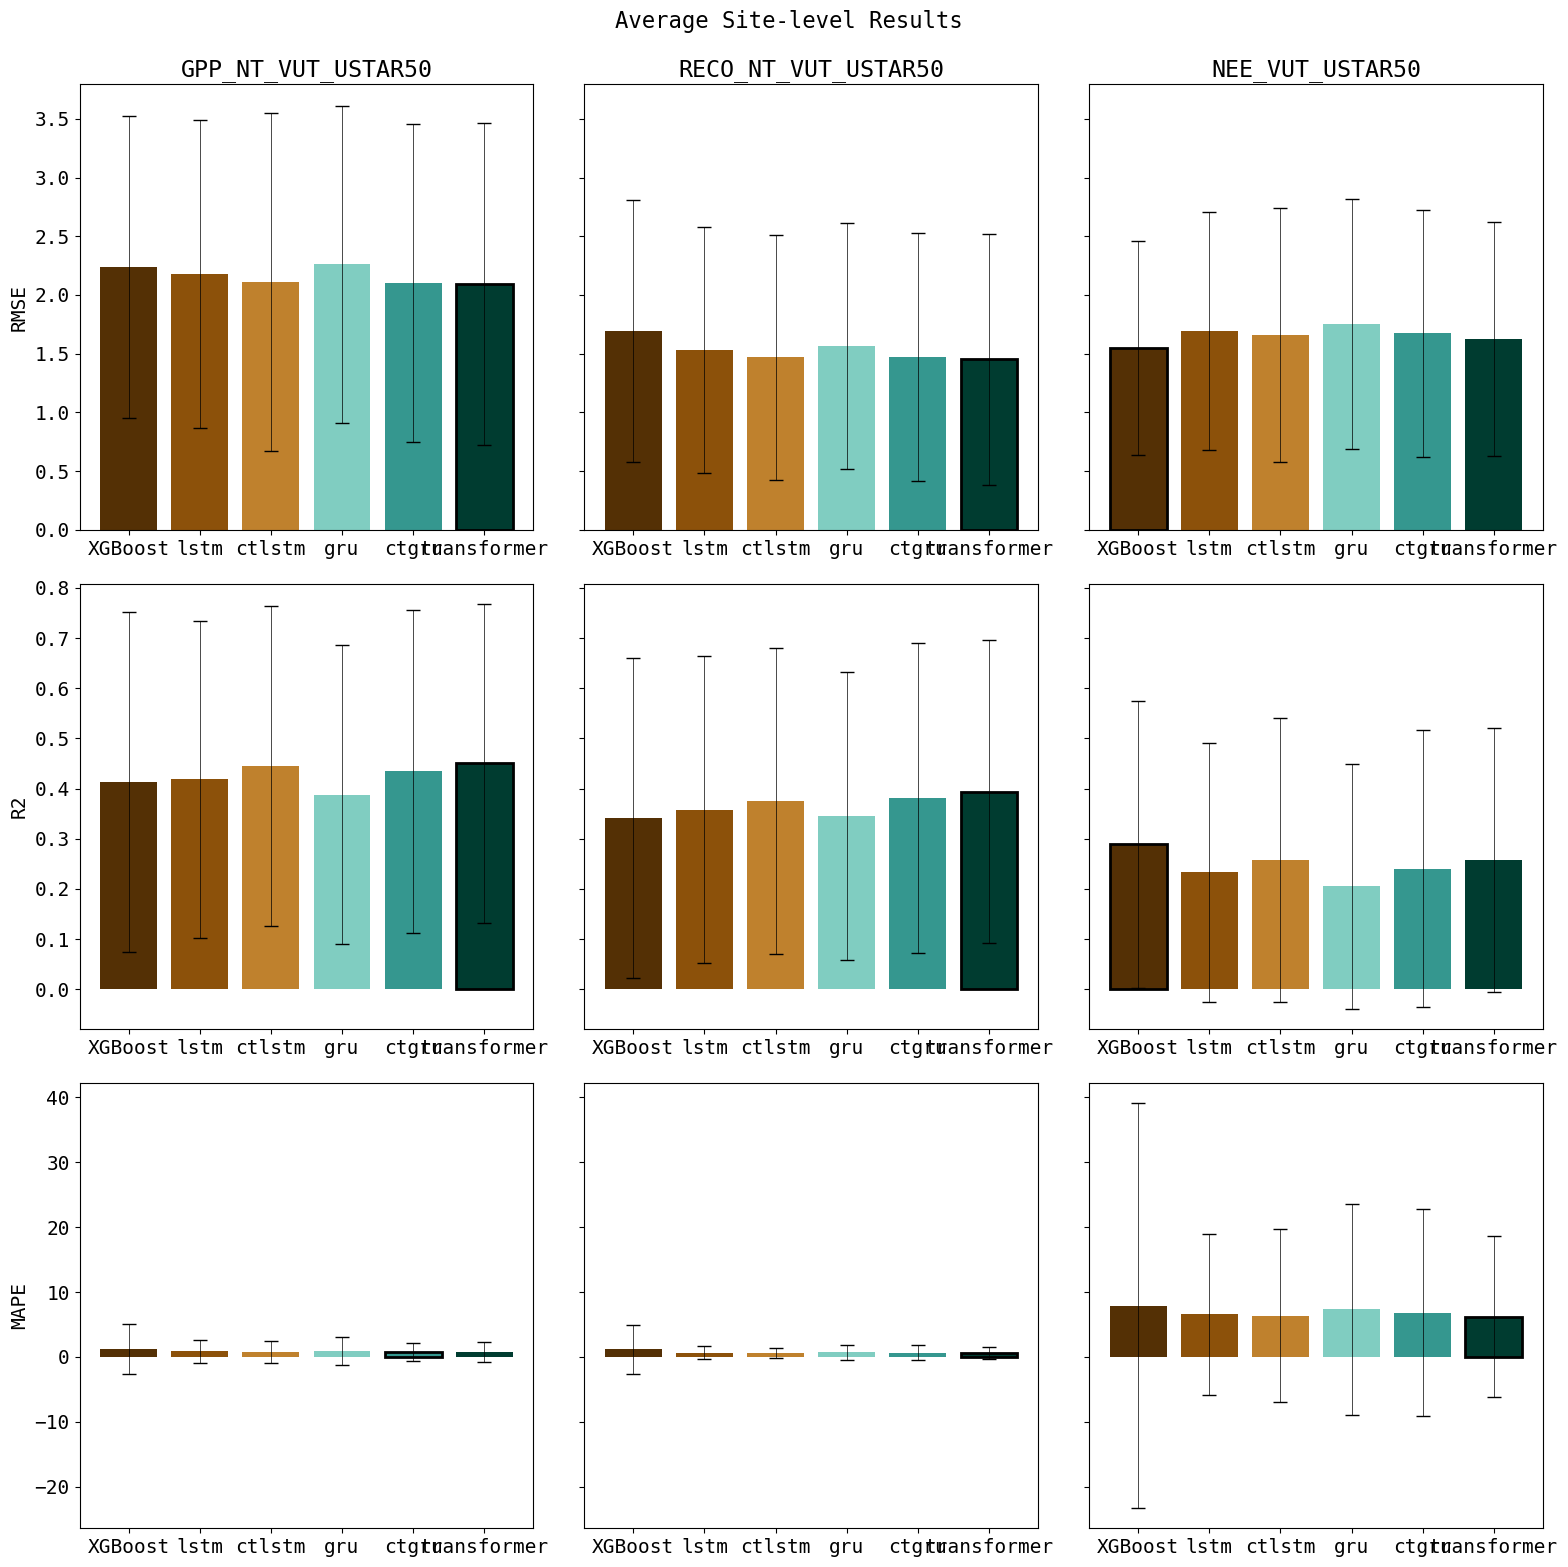

In [29]:
carbonbench.plot_bars(results, metrics, targets)

In [45]:
for target in targets:
    print("="*20, target, '='*20)
    for model in results.keys():
        res = round(results[model][target][metrics].mean().T,3)
        if len(model)<8:
            print(f"Model: {model}\t\tRMSE={res.RMSE.item()}\tR2={res.R2.item()}\tMAPE={res.MAPE.item()}")
        else:
            print(f"Model: {model}\tRMSE={res.RMSE.item()}\tR2={res.R2.item()}\tMAPE={res.MAPE.item()}")

==================== GPP_NT_VUT_USTAR50 ====================
Model: XGBoost		RMSE=2.24	R2=0.413	MAPE=1.247
Model: lstm		RMSE=2.178	R2=0.419	MAPE=0.896
Model: ctlstm		RMSE=2.11	R2=0.445	MAPE=0.808
Model: gru		RMSE=2.263	R2=0.388	MAPE=0.976
Model: ctgru		RMSE=2.101	R2=0.435	MAPE=0.789
Model: transformer	RMSE=2.093	R2=0.451	MAPE=0.802
==================== RECO_NT_VUT_USTAR50 ====================
Model: XGBoost		RMSE=1.692	R2=0.341	MAPE=1.154
Model: lstm		RMSE=1.533	R2=0.358	MAPE=0.691
Model: ctlstm		RMSE=1.47	R2=0.375	MAPE=0.629
Model: gru		RMSE=1.566	R2=0.345	MAPE=0.724
Model: ctgru		RMSE=1.471	R2=0.381	MAPE=0.67
Model: transformer	RMSE=1.453	R2=0.394	MAPE=0.619
==================== NEE_VUT_USTAR50 ====================
Model: XGBoost		RMSE=1.55	R2=0.289	MAPE=7.929
Model: lstm		RMSE=1.69	R2=0.234	MAPE=6.57
Model: ctlstm		RMSE=1.659	R2=0.257	MAPE=6.37
Model: gru		RMSE=1.752	R2=0.205	MAPE=7.321
Model: ctgru		RMSE=1.673	R2=0.241	MAPE=6.831
Model: transformer	RMSE=1.626	R2=0.258	MAPE=6.207


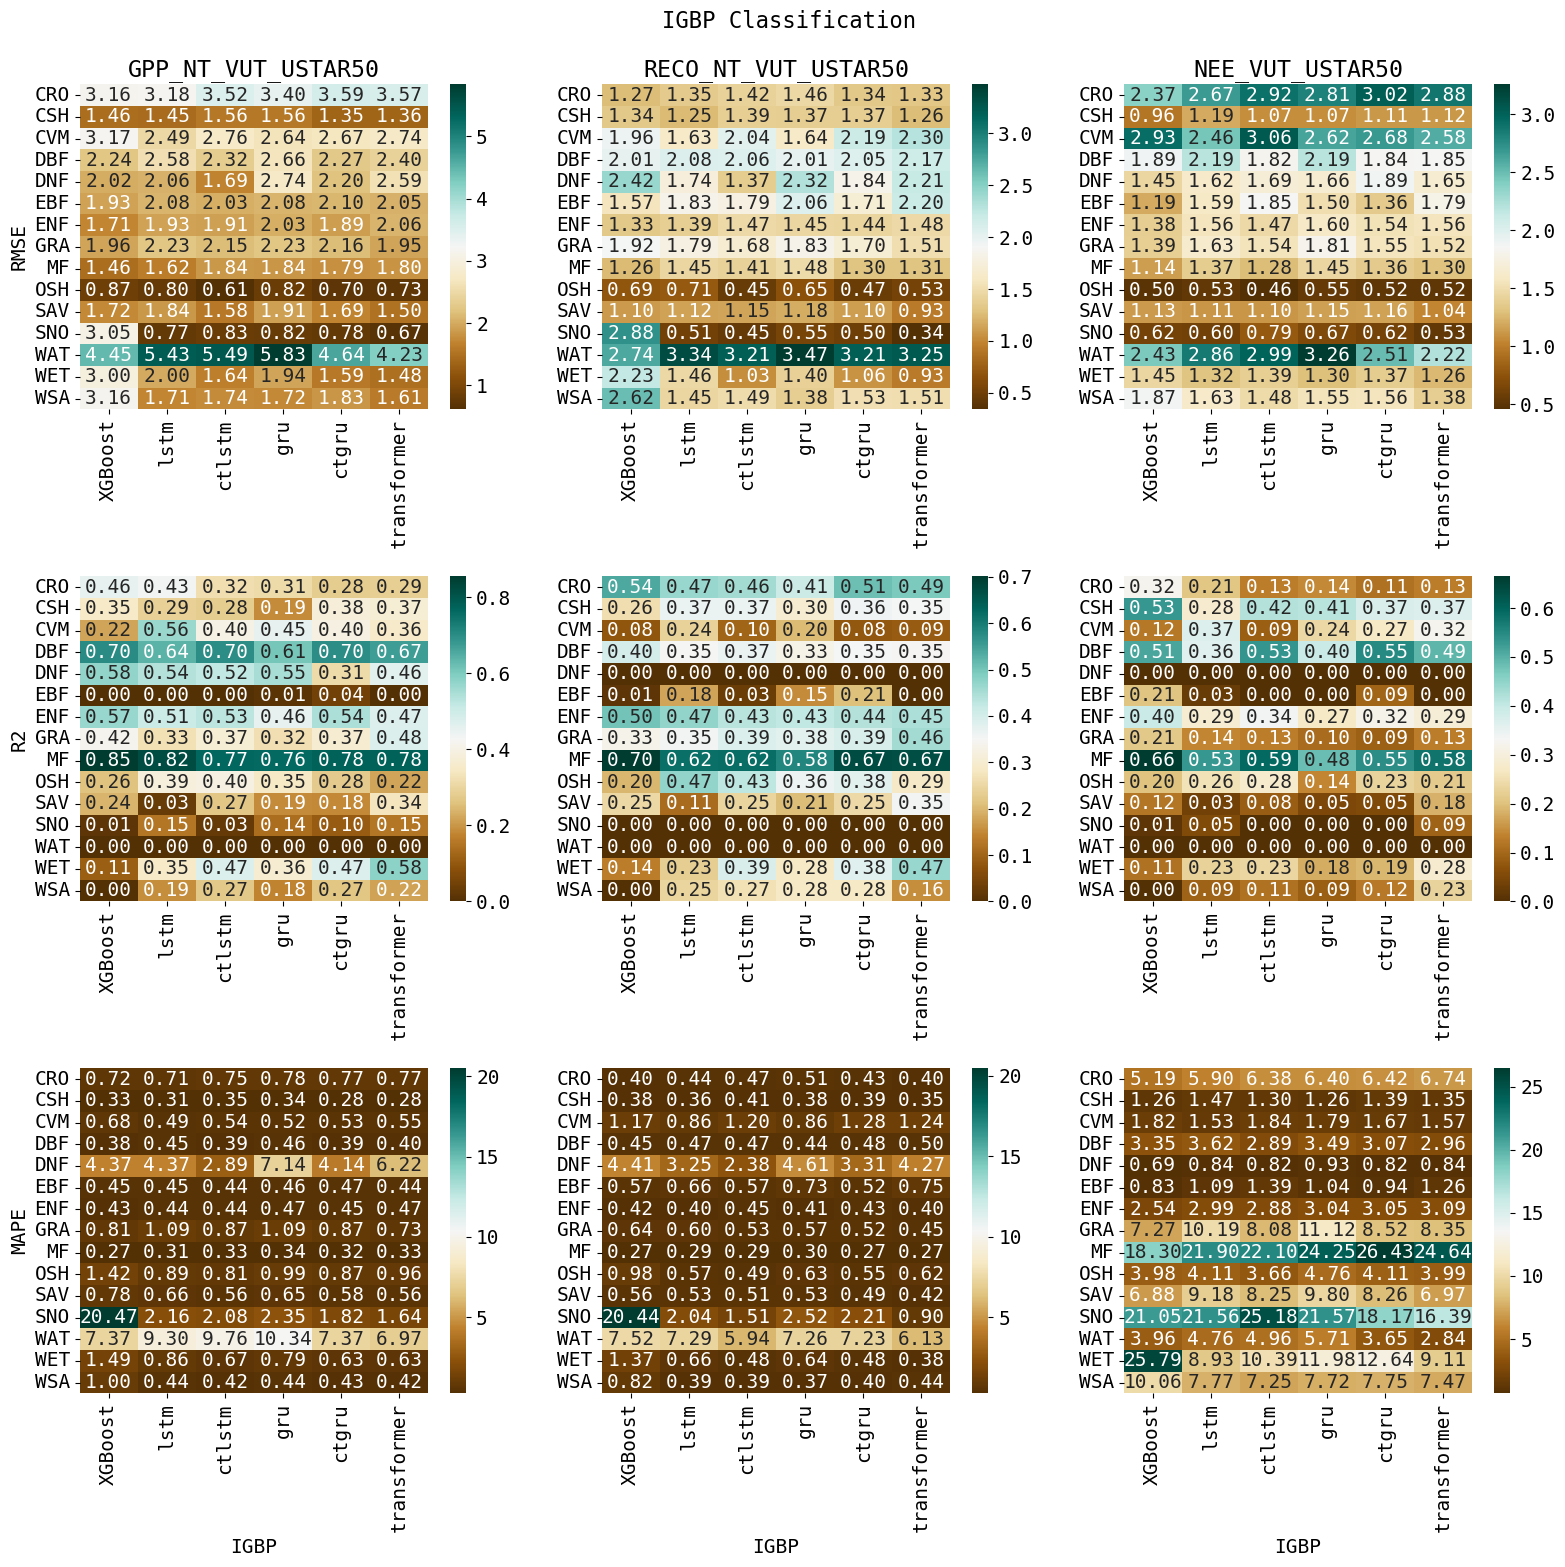

In [30]:
carbonbench.plot_heatmap(results, metrics, targets, classification='IGBP')

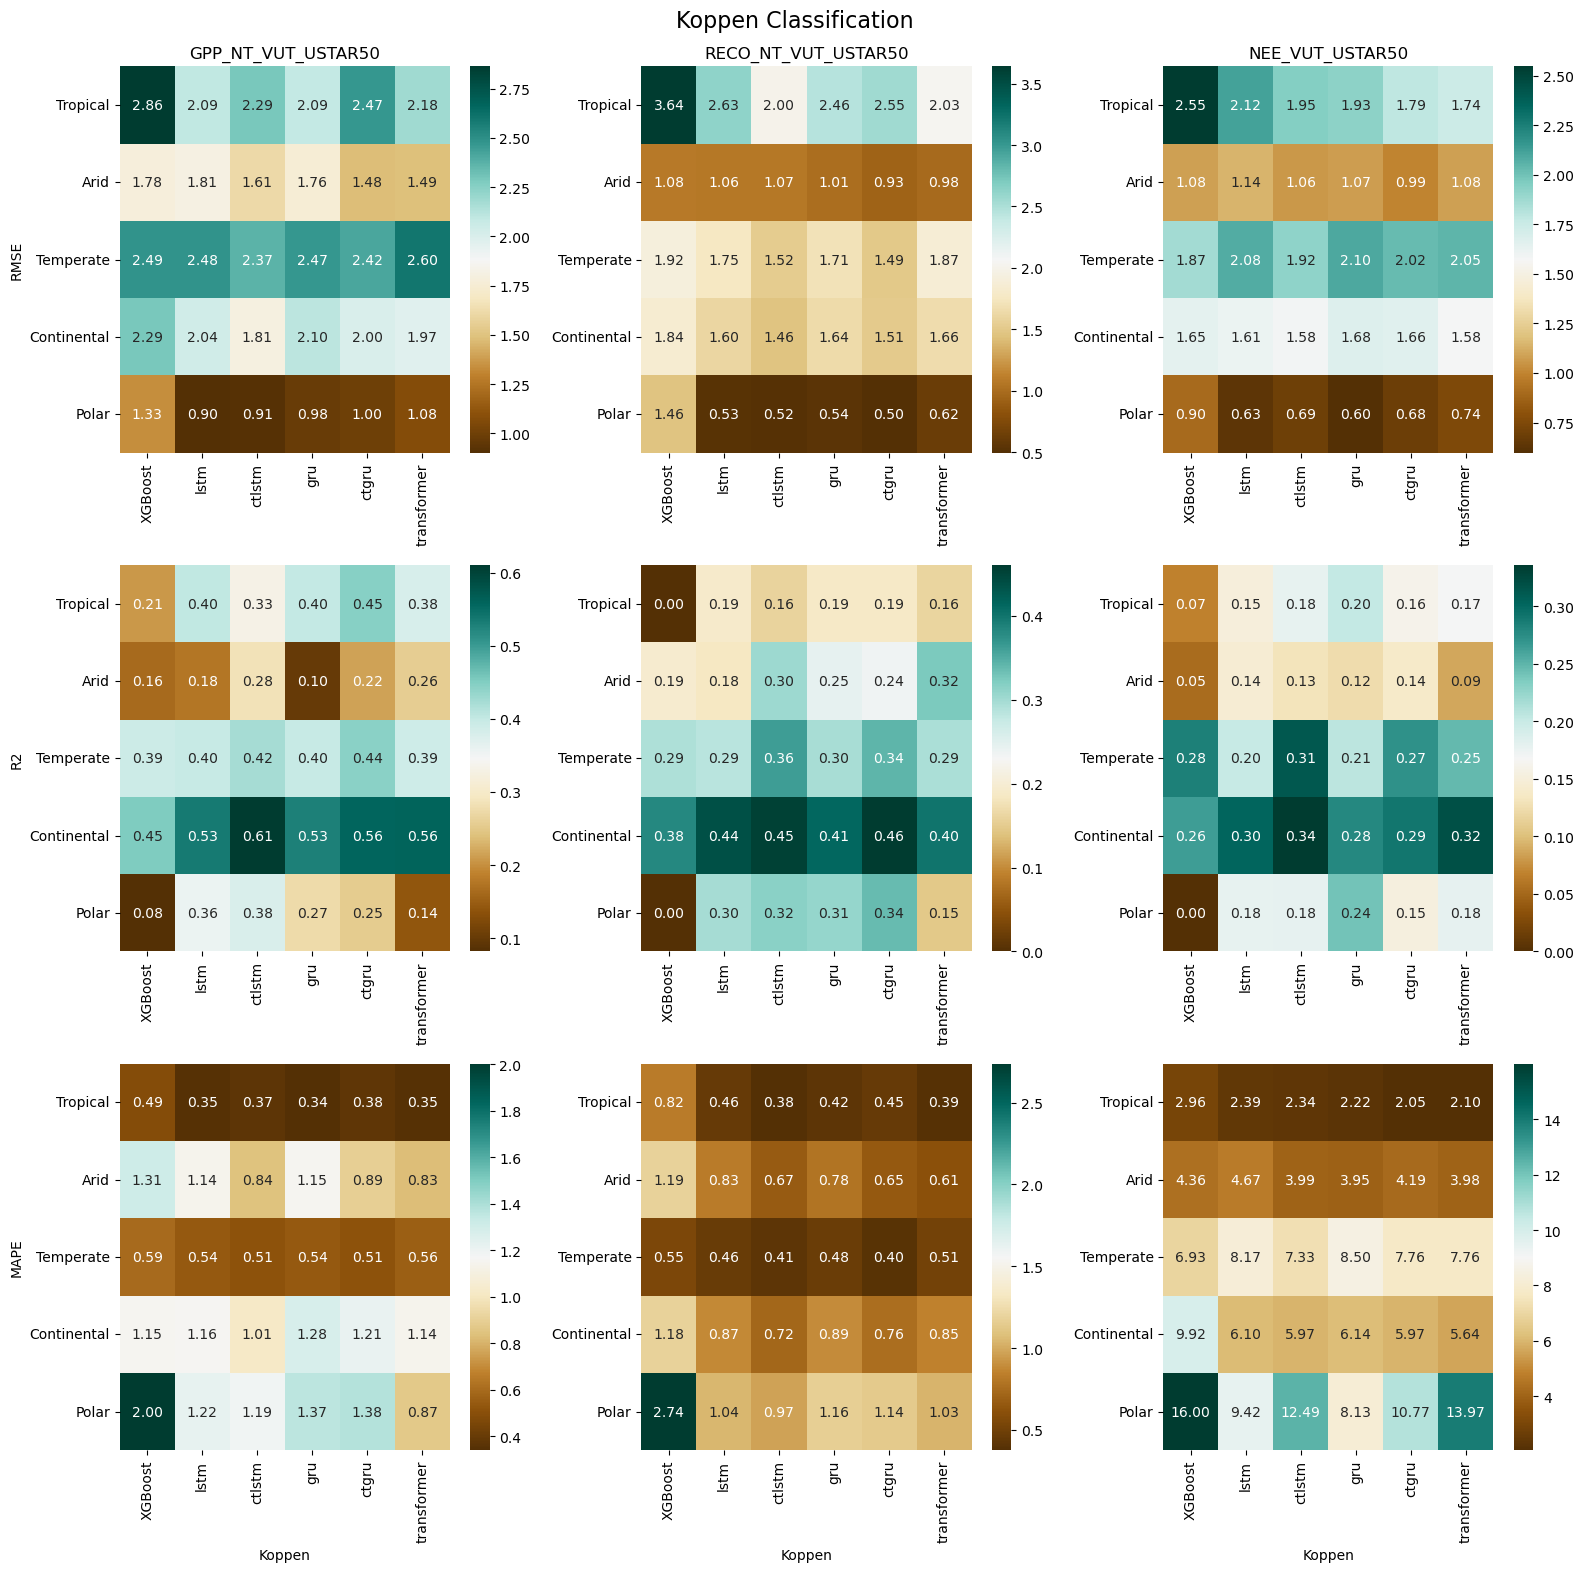

In [54]:
carbonbench.plot_heatmap(results, metrics, targets, classification='Koppen')